In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df6 = pd.read_csv('thyroid_encoded.csv')

print("Dataset shape:", df6.shape)
print("First few rows:")
print(df6.head())

print("Target variable distribution:")
print(df6['target'].value_counts())

Dataset shape: (7794, 23)
First few rows:
   age  TSH   T3    TT4  T4U  FTI  referral_source  sex  on_thyroxine  \
0   29  0.3  0.0    0.0  0.0  0.0                5    0             0   
1   29  1.6  1.9  128.0  0.0  0.0                5    0             0   
2   41  0.0  0.0    0.0  0.0  0.0                5    0             0   
3   36  0.0  0.0    0.0  0.0  0.0                5    0             0   
4   32  0.0  0.0    0.0  0.0  0.0                5    0             0   

   query_on_thyroxine  ...  thyroid_surgery  I131_treatment  \
0                   0  ...                0               0   
1                   0  ...                0               0   
2                   0  ...                0               0   
3                   0  ...                0               0   
4                   0  ...                0               0   

   query_hypothyroid  query_hyperthyroid  lithium  goitre  tumor  \
0                  1                   0        0       0      0   
1   

In [2]:
print("Missing values per column:")
missing_values = df6.isnull().sum()
print(missing_values[missing_values > 0])

Missing values per column:
Series([], dtype: int64)


In [3]:
!pip install imblearn

In [4]:
!pip install xgboost

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

X = df6.drop('target', axis=1)
y = df6['target']

In [6]:
le = LabelEncoder()
y = le.fit_transform(y)
print("Target classes after encoding:", le.classes_)
print("Encoded target distribution:", pd.Series(y).value_counts())

Target classes after encoding: [0 1 2]
Encoded target distribution: 2    6767
1     667
0     360
Name: count, dtype: int64


Training set shape: (6235, 22)
Testing set shape: (1559, 22)
Training target distribution: 2    5413
1     534
0     288
Name: count, dtype: int64
Testing target distribution: 2    1354
1     133
0      72
Name: count, dtype: int64
After SMOTE - Training set shape: (16239, 22)
After SMOTE - Training target distribution: 0    5413
2    5413
1    5413
Name: count, dtype: int64
Training XGBoost model
XGBoost Model Performance:
Accuracy: 0.9538
Precision (weighted): 0.9669
Recall (weighted): 0.9538
F1 Score (weighted): 0.9583
ROC AUC (average): 0.9928
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.86      0.66        72
           1       0.94      0.98      0.96       133
           2       0.99      0.96      0.97      1354

    accuracy                           0.95      1559
   macro avg       0.82      0.93      0.86      1559
weighted avg       0.97      0.95      0.96      1559



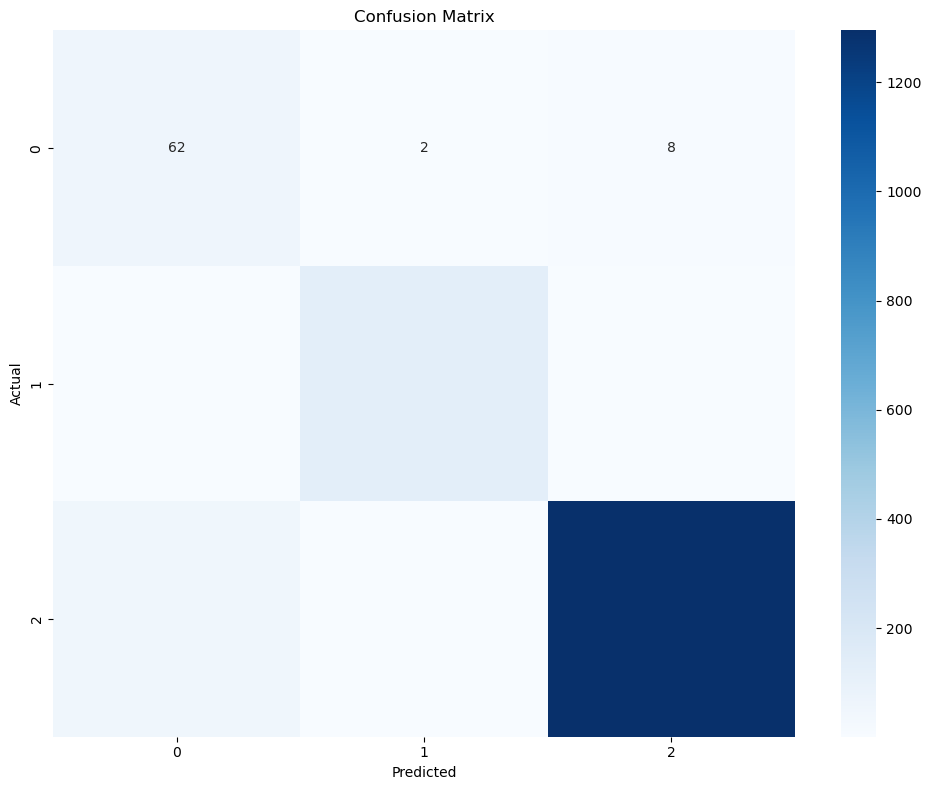

<Figure size 1200x800 with 0 Axes>

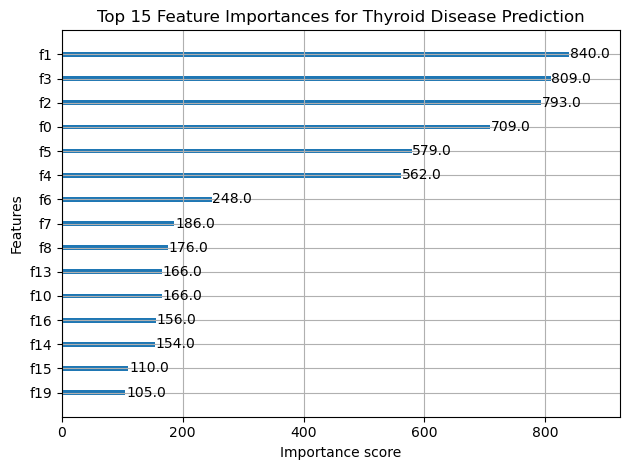

Model Summary:
XGBoost classifier was trained on thyroid dataset with SMOTE for handling class imbalance.
The model achieved 95.38% accuracy with weighted F1-score of 0.9583.
Average ROC AUC across all classes is 0.9928.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Training target distribution:", pd.Series(y_train).value_counts())
print("Testing target distribution:", pd.Series(y_test).value_counts())

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("After SMOTE - Training set shape:", X_train_resampled.shape)
print("After SMOTE - Training target distribution:", pd.Series(y_train_resampled).value_counts())

print("Training XGBoost model")
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_model.predict(X_test_scaled)
y_pred_proba = xgb_model.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# For multi-class ROC AUC, we use one-vs-rest approach
roc_auc = {}
for i in range(len(np.unique(y))):
    roc_auc[i] = roc_auc_score(y_test == i, y_pred_proba[:, i])


print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")
print(f"ROC AUC (average): {np.mean(list(roc_auc.values())):.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Top 15 Feature Importances for Thyroid Disease Prediction')
plt.tight_layout()
plt.show()

print("Model Summary:")
print("XGBoost classifier was trained on thyroid dataset with SMOTE for handling class imbalance.")
print(f"The model achieved {accuracy:.2%} accuracy with weighted F1-score of {f1:.4f}.")
print(f"Average ROC AUC across all classes is {np.mean(list(roc_auc.values())):.4f}.")

In [8]:
import joblib
import pickle
import os

os.makedirs('model', exist_ok=True)

joblib.dump(xgb_model, 'model/thyroid_xgboost_model.joblib')

joblib.dump(scaler, 'model/scaler.joblib')

with open('model/thyroid_xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [9]:
import joblib  
import numpy as np  
  
model = joblib.load('model/thyroid_xgboost_model.joblib')  
scaler = joblib.load('model/scaler.joblib')  
  
new_patient = pd.DataFrame({  
    'age': [54.0000],  
    'TSH': [1.2000],  
    'T3': [1.6000],  
    'TT4': [101.0000],  
    'T4U': [0.9400],  
    'FTI': [105.0000],  
    'referral_source': [5.0000],  
    'sex': [0.0000],  
    'on_thyroxine': [0.0000],  
    'query_on_thyroxine': [0.0000],  
    'on_antithyroid_meds': [0.0000],  
    'sick': [0.0000],  
    'pregnant': [0.0000],  
    'thyroid_surgery': [0.0000],  
    'I131_treatment': [0.0000],  
    'query_hypothyroid': [0.0000],  
    'query_hyperthyroid': [0.0000],  
    'lithium': [0.0000],  
    'goitre': [0.0000],  
    'tumor': [0.0000],  
    'hypopituitary': [0.0000],  
    'psych': [0.0000]  
})  

new_patient_scaled = scaler.transform(new_patient)  

predictions = model.predict(new_patient_scaled)  
prediction_probabilities = model.predict_proba(new_patient_scaled)  